<a href="https://colab.research.google.com/github/yaaili/test/blob/master/pytorch/02%E5%9F%BA%E4%BA%8EFashionMNIST%E7%9A%84%E6%A8%A1%E5%9E%8B%E5%89%AA%E6%9E%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 导入相关包

In [0]:
# 导入相关包
from google.colab import drive

drive.mount('/content/gdrive')
import os

os.chdir("/content/gdrive/My Drive/Colab Notebooks/pytorch深度学习")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import torch
from torch import nn
import torch.nn.functional as F
print(torch.__version__)

1.5.0+cu101


# 2 构建网络

In [0]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet,self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1, stride=1)
        self.relu3 = nn.ReLU(inplace=True)

        self.linear1 = nn.Linear(7 * 7 * 64, 128)
        self.linear2 = nn.Linear(128, 10)

        self.loss = nn.CrossEntropyLoss()

    def forward(self, data):
        out = self.maxpool1(self.relu1(self.conv1(data)))
        out = self.maxpool2(self.relu2(self.conv2(out)))
        out = self.relu3(self.conv3(out))
        out = out.view(out.size(0), -1)
        out = self.linear1(out)
        out = self.linear2(out)
        return out

    def get_loss(self, output, label):
        return self.loss(output, label)


In [0]:
if __name__ == '__main__':
    net = MyNet()
    for p in net.conv1.parameters():
        print(p.data.size())
    for p in net.linear1.parameters():
        print(p.data.size())

torch.Size([32, 1, 3, 3])
torch.Size([32])
torch.Size([128, 3136])
torch.Size([128])


In [0]:
total = sum([param.nelement() for param in net.parameters()])
print('  + Number of params: %.2fM' % (total / 1e6))


  + Number of params: 0.46M


# 3 训练

In [0]:
import torch
from torchvision import datasets, transforms

from torch.utils.data import DataLoader
import math
import time

## 3.1 数据准备

In [0]:
#图像的预处理归一化[0,1],transforms.Normalize即image=(image-mean)/std到[-1,1]
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
#加载训练集,不是独热编码
train_data = DataLoader(datasets.FashionMNIST("./datasets/", train=True, transform=trans, download=True),
                              batch_size=100, shuffle=True, drop_last=True)
#加载测试集
test_data = DataLoader(datasets.FashionMNIST("./datasets/", train=False, transform=trans, download=True),
                               batch_size=100, shuffle=True, drop_last=True)

In [0]:
for X,y in train_data:
    print(X.shape,y.shape)
    break

torch.Size([100, 1, 28, 28]) torch.Size([100])


In [0]:
class Trainer:
    def __init__(self, save_path):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.save_path = save_path
        self.net = MyNet().to(self.device)
        self.optimizer = torch.optim.Adam(self.net.parameters())
        self.net.train()
        
    def evaluate_accuracy(self,test_data):
        acc_sum, n = 0.0, 0
        for X, y in test_data:
            X, y = X.to(self.device), y.to(self.device)
            if isinstance(self.net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (self.net(X).argmax(dim=1) == y).float().sum().item()
                net.train() # 改回训练模式
            else: # 自定义的模型
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (self.net(X, is_training=False).argmax(dim=1) == y).float().sum().item() 
                else:
                    acc_sum += (self.net(X).argmax(dim=1) == y).float().sum().item() 
            n += y.shape[0]
        return acc_sum / n

    def train(self,train_data,test_data,epochs):
        for epoch in range(1, epochs):
            total = 0
            train_acc_sum,train_l_sum,n,start = 0.0,0.0,0,time.time()
            for i, (data, label) in enumerate(train_data):
                data, label = data.to(self.device), label.to(self.device)
                output = self.net(data)
                loss = self.net.get_loss(output, label)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total += len(data)
                #训练损失
                train_l_sum += loss.item()
                train_acc_sum += ((output.argmax(dim=1)) == label).sum().item()
                n += 100  
                progress = math.ceil(i / len(train_data) * 50)
                print("\rTrain epoch %d: %d/%d, [%-51s] %d%%" %
                      (epoch, total, len(train_data.dataset),
                       '-' * progress + '>', progress * 2), end='')
            test_acc = self.evaluate_accuracy(test_data)
            print("\nepoch %d,loss %.4f, train_acc %.3f, test_acc %.3f,time %.1f sec"
              %(epoch,train_l_sum/n,train_acc_sum/n,test_acc,time.time()-start))
              
            torch.save(self.net.state_dict(), self.save_path)





In [0]:
if __name__ == '__main__':
    trainer = Trainer("./model/finsh_minst_net.pth")
    trainer.train(train_data,test_data,epochs=10)

Train epoch 1: 60000/60000, [-------------------------------------------------->] 100%
epoch 1,loss 0.0045, train_acc 0.836, test_acc 0.877,time 11.8 sec
Train epoch 2: 60000/60000, [-------------------------------------------------->] 100%
epoch 2,loss 0.0028, train_acc 0.899, test_acc 0.897,time 11.8 sec
Train epoch 3: 60000/60000, [-------------------------------------------------->] 100%
epoch 3,loss 0.0024, train_acc 0.913, test_acc 0.899,time 12.0 sec
Train epoch 4: 60000/60000, [-------------------------------------------------->] 100%
epoch 4,loss 0.0021, train_acc 0.923, test_acc 0.909,time 11.8 sec
Train epoch 5: 60000/60000, [-------------------------------------------------->] 100%
epoch 5,loss 0.0019, train_acc 0.930, test_acc 0.917,time 12.1 sec
Train epoch 6: 60000/60000, [-------------------------------------------------->] 100%
epoch 6,loss 0.0017, train_acc 0.938, test_acc 0.912,time 11.9 sec
Train epoch 7: 60000/60000, [-----------------------------------------------

# 4 对模型进行剪枝
## 4.1 构建剪枝网络

In [0]:
import torch
import torch.nn.utils.prune as prune

class Pruning:
    #net_path是修建的模型，amount是模型的修建率
    def __init__(self, net_path, amount):
        self.net = MyNet()
        #加载模型
        self.net.load_state_dict(torch.load(net_path))
        #将模型都定义为元组,这是全局修剪的方法
        self.parameters_to_prune = (
            (self.net.conv1, 'weight'),
            (self.net.conv2, 'weight'),
            (self.net.conv3, 'weight'),
            (self.net.linear1, 'weight'),
            (self.net.linear2, 'weight'),
        )
        self.amount = amount

    def pruning(self):
      #全局修剪参数，方法是修剪绝对值参数
        prune.global_unstructured(
            self.parameters_to_prune,
            pruning_method=prune.L1Unstructured,
            amount=self.amount,
        )
        # print(self.net.state_dict().keys())
        # 删除weight_orig 、weight_mask以及forward_pre_hook
        prune.remove(self.net.conv1, 'weight')
        prune.remove(self.net.conv2, 'weight')
        prune.remove(self.net.conv3, 'weight')
        prune.remove(self.net.linear1, 'weight')
        prune.remove(self.net.linear2, 'weight')
        print(
            "Sparsity in conv1.weight: {:.2f}%".format(
                100. * float(torch.sum(self.net.conv1.weight == 0))
                / float(self.net.conv1.weight.nelement())
            )
        )
        print(
            "Sparsity in conv2.weight: {:.2f}%".format(
                100. * float(torch.sum(self.net.conv2.weight == 0))
                / float(self.net.conv2.weight.nelement())
            )
        )
        print(
            "Sparsity in conv3.weight: {:.2f}%".format(
                100. * float(torch.sum(self.net.conv3.weight == 0))
                / float(self.net.conv3.weight.nelement())
            )
        )
        print(
            "Sparsity in linear1.weight: {:.2f}%".format(
                100. * float(torch.sum(self.net.linear1.weight == 0))
                / float(self.net.linear1.weight.nelement())
            )
        )
        print(
            "Sparsity in linear2.weight: {:.2f}%".format(
                100. * float(torch.sum(self.net.linear2.weight == 0))
                / float(self.net.linear2.weight.nelement())
            )
        )
        print(
            "Global sparsity: {:.2f}%".format(
                100. * float(
                    torch.sum(self.net.conv1.weight == 0)
                    + torch.sum(self.net.conv2.weight == 0)
                    + torch.sum(self.net.conv3.weight == 0)
                    + torch.sum(self.net.linear1.weight == 0)
                    + torch.sum(self.net.linear2.weight == 0)
                )
                / float(
                    self.net.conv1.weight.nelement()
                    + self.net.conv2.weight.nelement()
                    + self.net.conv3.weight.nelement()
                    + self.net.linear1.weight.nelement()
                    + self.net.linear2.weight.nelement()
                )
            )
        )
        # torch.save(self.net.state_dict(), "models/pruned_net_with_conv.pth")
        torch.save(self.net.state_dict(), f"./model/pruned_net_with_torch_{self.amount:.1f}_l1.pth")


if __name__ == '__main__':
    for i in range(1, 10):
        pruning = Pruning("./model/finsh_minst_net.pth", 0.1 * i)
        pruning.pruning()


NameError: ignored

# 5 检测

In [0]:
class Detector:
    def __init__(self, net_path):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.net = MyNet().to(self.device)
        self.map_location = None if torch.cuda.is_available() else lambda storage, loc: storage
        self.net.load_state_dict(torch.load(net_path, map_location=self.map_location))
        self.net.eval()

    def detect(self,test_data):
        test_loss = 0
        correct = 0
        start = time.time()
        with torch.no_grad():
            for data, label in test_data:
                data, label = data.to(self.device), label.to(self.device)
                output = self.net(data)
                test_loss += self.net.get_loss(output, label)
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct += pred.eq(label.view_as(pred)).sum().item()

        end = time.time()
        print(f"total time:{end - start}")
        test_loss /= len(test_data.dataset)

        print('Test: average loss: {:.4f}, accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_data.dataset),
            100. * correct / len(test_data.dataset)))
        #返回的损失和正确率
        return [test_loss,correct/len(test_data.dataset)]


if __name__ == '__main__':
    print("./model/finsh_minst_net.pth")
    test_loss,accuracy,Parameter_compression_ratio = [],[],[]
    detector1 = Detector("./model/finsh_minst_net.pth")
    loss,acc = detector1.detect(test_data)

    test_loss.append(loss)
    accuracy.append(acc)   
    Parameter_compression_ratio.append(0)
     
    for i in range(1, 10):
        amount = 0.1 * i
        print(f"./model/pruned_net_with_torch_{amount:.1f}_l1.pth")
        detector1 = Detector(f"./model/pruned_net_with_torch_{amount:.1f}_l1.pth")
        loss,acc = detector1.detect(test_data)

        test_loss.append(loss)
        accuracy.append(acc)   
        Parameter_compression_ratio.append(amount)


./model/finsh_minst_net.pth
total time:1.6475636959075928
Test: average loss: 0.0027, accuracy: 9179/10000 (92%)

./model/pruned_net_with_torch_0.1_l1.pth
total time:1.3875453472137451
Test: average loss: 0.0027, accuracy: 9179/10000 (92%)

./model/pruned_net_with_torch_0.2_l1.pth
total time:1.5390675067901611
Test: average loss: 0.0027, accuracy: 9179/10000 (92%)

./model/pruned_net_with_torch_0.3_l1.pth
total time:1.356163501739502
Test: average loss: 0.0026, accuracy: 9178/10000 (92%)

./model/pruned_net_with_torch_0.4_l1.pth
total time:1.4721436500549316
Test: average loss: 0.0026, accuracy: 9163/10000 (92%)

./model/pruned_net_with_torch_0.5_l1.pth
total time:1.429352045059204
Test: average loss: 0.0026, accuracy: 9134/10000 (91%)

./model/pruned_net_with_torch_0.6_l1.pth
total time:1.3589565753936768
Test: average loss: 0.0026, accuracy: 9119/10000 (91%)

./model/pruned_net_with_torch_0.7_l1.pth
total time:1.3456928730010986
Test: average loss: 0.0028, accuracy: 9026/10000 (90%)


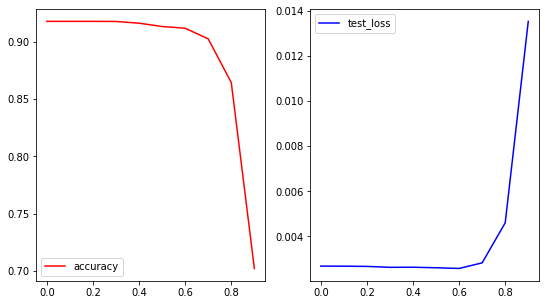

In [0]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2,figsize=(9,5))
ax1 = plt.subplot(121)  #绘制子图1对象
ax2 = plt.subplot(122)  #绘制子图2对象



x = Parameter_compression_ratio
y = accuracy
y2 = test_loss

ax1.plot(x,y,color='red',label='accuracy')
ax2.plot(x,y2,color='blue',label='test_loss')
ax1.legend()
ax2.legend()

plt.show()